# Preparations

In [84]:
import sys
import math
import copy
import itertools
import numpy as np
import collections

import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.mlab import griddata
from matplotlib.ticker import NullFormatter
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from higgs_inference.various.utils import interpolate, format_number, asymptotic_p_value
from higgs_inference import settings


# Settings

In [85]:
# Which benchmark point to use
use_not_trained_benchmark = True

# Which algorithm to use for the PbP vs parameterized vs morphing-aware plot
use_regression_as_pbp_param_aware_example = False  # If False, use carl

# Neyman construction settings
neyman_plots = True
remove_duplicates_for_nc = False

# Neyman observed
neyman_observed_experiment = 2

# Asymptotics settings
use_median_rather_than_asimov = False

# Interpolation
interpolation_method = 'linear' #'linear', 'gp'


In [86]:
#colors     = ['0.65']  + ['orange', 'darkgreen',  '#be96ff', 'mediumblue', 'c', '#CC002E', 'SlateGray', 'black'] * 2
#linestyles = ['-'] + [':',        '--',  '-.',          '-.',     ':',      '--', '-',    '-']*2

colors     = ['black']  + ['0.65', '0.65', '0.65', 'orange', '#CC002E'] * 4
linestyles = ['-'] + [':', '-.', '--', ':', '--']*4

band_alpha = [0.15 if c in ['0.65', 'darkgreen', 'mediumblue', '#CC002E'] else 0.5 for c in colors]
linewidths = [1.5 if ls == ':' else 1.5 for ls in linestyles]

scatter_alpha = 1.

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb


In [87]:
thetas = np.load('../data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_observed = 0
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

if use_not_trained_benchmark:
    theta_benchmark = 9
    benchmark_name = 'nottrained'
else:
    theta_benchmark = 422
    benchmark_name = 'trained'
    
pbp_training_thetas = [0, 13, 14, 15, 16, 9, 422, 956, 666, 802, 675, 839, 699, 820, 203, 291, 634, 371, 973, 742, 901, 181, 82, 937, 510, 919, 745, 588, 804, 963, 396, 62, 401, 925, 874, 770, 108, 179, 669, 758, 113, 587, 600, 975, 496, 66, 467, 412, 701, 986, 598, 810, 97, 18, 723, 159, 320, 301, 352, 159, 89, 421, 574, 923, 849, 299, 119, 167, 939, 402, 52, 787, 978, 41, 873, 533, 827, 304, 294, 760, 890, 539, 1000, 291, 740, 276, 679, 167, 125, 429, 149, 430, 720, 123, 908, 256, 777, 809, 269, 851]
basis_thetas = [0, 101, 106, 902, 910,
                226, 373, 583, 747, 841,
                599, 709, 422, 367, 167]
thetas_highlighted = []

#print(thetas[theta1])
#print(thetas[theta_benchmark])

#X_observed = np.load('../data/unweighted_events/X_test.npy')

In [88]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_t_absolute_extra = 8. * 0.14
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace,
                        hspace = hspace)
    

# Define strategies and load results

In [89]:
def _load(name, folder='parameterized'):
    return np.load('../results/' + folder + '/' + name + '.npy')

def add_strategy(label, suffix, folder,
                 suffices_ensemble=None,
                 panel=-1, is_truth=False,
                 zorder=0):
    
    neyman_string = 'neyman3' if remove_duplicates_for_nc else 'neyman2'
    
    try:
        _expected_llr = _load('llr_' + suffix, folder)
        _r_benchmark = _load('r_' + benchmark_name + '_' + suffix, folder)
    except IOError:
        print('Results for strategy ' + label + ' not found')
        return
    
    try:
        _mse_log_r = _load('mse_logr_' + suffix, folder)
        _trimmed_mse_log_r = _load('trimmed_mse_logr_' + suffix, folder)
        do_mse_log_r = True
    except IOError:
        _mse_log_r = None
        _trimmed_mse_log_r = None
        do_mse_log_r = False
        
    if suffices_ensemble is not None:
        try:
            _expected_llr_ensemble = []
            for i in range(4):
                _filename = 'llr_' + suffices_ensemble.replace(r'%i', str(i+1))
                _expected_llr_ensemble.append(_load(_filename, folder))
            do_diagnostics = True
        except IOError:
            do_diagnostics = False
            _expected_llr_ensemble = None
    else:
        do_diagnostics = False
        _expected_llr_ensemble = None
    
    try:
        _p_values = _load(neyman_string + '_pvalues_' + suffix, folder)
        _q_thresholds = _load(neyman_string + '_qcut_' + suffix, folder)
        _q_threshold_uncertainties = _load(neyman_string + '_qcut_uncertainties_' + suffix, folder)
        _q_medians = _load(neyman_string + '_qmedian_' + suffix, folder)
        _q_observeds = _load(neyman_string + '_qobserved_' + suffix, folder)
        do_neyman = True
        
        assert not np.all(np.isnan(_q_thresholds)), 'q thresholds contain only NaNs'
        assert not np.all(np.isnan(_q_medians)), 'q medians contain only NaNs'
        assert not np.all(np.isnan(_q_threshold_uncertainties)), 'q threshold uncertainties contain only NaNs'
    except IOError:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        _q_observeds = None
        do_neyman = False
    except AssertionError as err:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        _q_observeds = None
        do_neyman = False
        
    try:
        _r_roam = _load('r_roam_' + suffix, folder)
        do_roaming = True
    except IOError:
        _r_roam = None
        do_roaming = False
        
    labels.append(label)
    suffices.append(suffix)
    
    expected_llr.append(_expected_llr)
    expected_llr_ensemble.append(_expected_llr_ensemble)
    mse_log_r.append(_mse_log_r)
    trimmed_mse_log_r.append(_trimmed_mse_log_r)
    p_values.append(_p_values)
    q_medians.append(_q_medians)
    q_observeds.append(_q_observeds)
    q_threshold_uncertainties.append(_q_threshold_uncertainties)
    q_thresholds.append(_q_thresholds)
    r_benchmark.append(_r_benchmark)
    
    index = len(labels) - 1
    if is_truth:
        truth_index = index
    if panel >= 0 and panel < len(panel_indices):
        panel_indices[panel].append(index)
    
    zorders.append(zorder)
        
    if (do_neyman or do_diagnostics):
        supported = []
        if do_diagnostics:
            supported.append('ensemble')
        if do_neyman:
            supported.append('NC')
        supported = ', '.join(supported)
            
        print('Loaded strategy {}: {} ({})'.format(len(labels) - 1, label, supported))
        
    else:
        print('Loaded strategy {}: {}'.format(len(labels) - 1, label))
    

In [104]:
labels = []
suffices = []
folders = []

truth_index = 0
panel_indices = ([], [], [], [])

expected_llr = []
expected_llr_ensemble = []
mse_log_r = []
trimmed_mse_log_r = []
p_values = []
q_medians = []
q_observeds = []
q_thresholds = []
q_threshold_uncertainties = []
r_benchmark = []

zorders = []

add_strategy('Truth', 'truth', 'truth', is_truth=True)

add_strategy('2D histogram', 'histo_2d_asymmetricbinning', 'histo', 'histo_2d_asymmetricbinning_denom%i', panel=0)
#add_strategy('CARL', 'carl_calibrated_shallow', 'parameterized', 'carl_calibrated_shallow_denom%i')
#add_strategy('CASCAL', 'combined_calibrated_deep', 'parameterized', 'combined_calibrated_deep_denom%i')
add_strategy('SALLY', 'scoreregression_rotatedscore_deep', 'score_regression', 'scoreregression_rotatedscore_deep_denom%i', panel=0)
#add_strategy('ROLR', 'regression_calibrated', 'parameterized', 'regression_calibrated_denom%i')
add_strategy('RASCAL', 'combinedregression_calibrated_deep', 'parameterized', 'combinedregression_calibrated_deep_denom%i', panel=0)
add_strategy('ALICE', 'mxe_calibrated_deep', 'parameterized', 'mxe_calibrated_deep_denom%i', panel=0, zorder=5)
add_strategy('ALICES', 'combinedmxe_calibrated_deep', 'parameterized', 'combinedmxe_calibrated_deep_denom%i', panel=0)

add_strategy('2D histogram', 'histo_2d_asymmetricbinning_smeared', 'histo', panel=1)
#add_strategy('CARL', 'carl_calibrated_shallow_smeared', 'parameterized')
#add_strategy('CASCAL', 'combined_calibrated_deep_smeared', 'parameterized')
add_strategy('SALLY', 'scoreregression_rotatedscore_deep_smeared', 'score_regression', panel=1)
#add_strategy('ROLR', 'regression_calibrated_smeared', 'parameterized')
add_strategy('RASCAL', 'combinedregression_calibrated_deep_smeared', 'parameterized', panel=1)
add_strategy('ALICE', 'mxe_calibrated_deep_smeared', 'parameterized', panel=1, zorder=5)
add_strategy('ALICES', 'combinedmxe_calibrated_deep_smeared', 'parameterized', panel=1)

add_strategy('2D histogram', 'histo_2d_asymmetricbinning', 'histo', panel=2)
add_strategy('SALLY', 'scoreregression_rotatedscore_deep_trainingsamplesize_100000', 'score_regression', panel=2)
add_strategy('RASCAL', 'combinedregression_calibrated_deep_trainingsamplesize_100000', 'parameterized', panel=2)
add_strategy('ALICE', 'mxe_calibrated_deep_trainingsamplesize_100000', 'parameterized', panel=2, zorder=5)
add_strategy('ALICES', 'combinedmxe_calibrated_deep_trainingsamplesize_100000', 'parameterized', panel=2)

add_strategy('2D histogram', 'histo_2d_asymmetricbinning_smeared', 'histo', panel=3)
add_strategy('SALLY', 'scoreregression_rotatedscore_deep_smeared_trainingsamplesize_100000', 'score_regression', panel=3)
add_strategy('RASCAL', 'combinedregression_calibrated_deep_smeared_trainingsamplesize_100000', 'parameterized', panel=3)
add_strategy('ALICE', 'mxe_calibrated_deep_smeared_trainingsamplesize_100000', 'parameterized', panel=3, zorder=5)
add_strategy('ALICES', 'combinedmxe_calibrated_deep_smeared_trainingsamplesize_100000', 'parameterized', panel=3)

n_strategies = len(labels)

Loaded strategy 0: Truth (NC)
Loaded strategy 1: 2D histogram (ensemble, NC)
Loaded strategy 2: SALLY (ensemble, NC)
Loaded strategy 3: RASCAL (ensemble, NC)
Loaded strategy 4: ALICE (NC)
Loaded strategy 5: ALICES (NC)
Loaded strategy 6: 2D histogram (NC)
Loaded strategy 7: SALLY (NC)
Loaded strategy 8: RASCAL (NC)
Loaded strategy 9: ALICE (NC)
Loaded strategy 10: ALICES (NC)
Loaded strategy 11: 2D histogram (NC)
Loaded strategy 12: SALLY (NC)
Loaded strategy 13: RASCAL
Loaded strategy 14: ALICE (NC)
Loaded strategy 15: ALICES
Loaded strategy 16: 2D histogram (NC)
Results for strategy SALLY not found
Results for strategy RASCAL not found
Results for strategy ALICE not found
Results for strategy ALICES not found


# Interpolation

In [100]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

interpolated_q_medians = []
interpolated_q_observeds = []
interpolated_q_thresholds = []
interpolated_cl_excluded = []
interpolated_cl_excluded_observed = []

for i, (_q_median, _q_observed, _q_threshold, _q_threshold_uncertainty) in \
    enumerate(zip(q_medians, q_observeds, q_thresholds, q_threshold_uncertainties)):

    print('Starting strategy {} / {}'.format(i + 1, n_strategies))

    if _q_median is None or _q_observed is None or _q_threshold is None or _q_threshold_uncertainty is None:
        interpolated_q_medians.append(None)
        interpolated_q_observeds.append(None)
        interpolated_q_thresholds.append(None)
        interpolated_cl_excluded.append(None)
        interpolated_cl_excluded_observed.append(None)
        continue

    try:
        cut = np.all(np.isfinite(_q_threshold),axis=1) & (np.isfinite(_q_median)) & np.all(np.isfinite(_q_threshold_uncertainty),axis=1)

        _interpolated_q_median, _ = interpolate(thetas[cut], _q_median[cut],
                                                xx, yy,
                                                method=interpolation_method,
                                                length_scale_default=0.1, length_scale_min=0.01,
                                                length_scale_max=1.,
                                                matern_exponent=2.5,
                                                noise_level=0.01)

        _interpolated_q_observed, _ = interpolate(thetas[cut], _q_observed[cut, neyman_observed_experiment],
                                                  xx, yy,
                                                  method=interpolation_method,
                                                  length_scale_default=0.1, length_scale_min=0.01,
                                                  length_scale_max=1.,
                                                  matern_exponent=2.5,
                                                  noise_level=0.01)

        _interpolated_q_thresholds = []
        for j in range(len(settings.confidence_levels)):
            _qthresh, _ = interpolate(thetas[cut], _q_threshold[cut, j], xx, yy,
                                     z_uncertainties_thetas=2*_q_threshold_uncertainty[cut, j],
                                     method=interpolation_method,
                                     length_scale_default=1., length_scale_min=0.5, length_scale_max=2.,
                                     matern_exponent=2.5,
                                     noise_level=0.01)
            _interpolated_q_thresholds.append(copy.deepcopy(_qthresh))
        _interpolated_q_thresholds = np.asarray(_interpolated_q_thresholds)

        _interpolated_cl_excluded = np.asarray([_interpolated_q_median - _interpolated_q_thresholds[j]
                                                for j in range(_interpolated_q_thresholds.shape[0])])
        _interpolated_cl_excluded_observed = np.asarray([_interpolated_q_observed - _interpolated_q_thresholds[j]
                                                         for j in range(_interpolated_q_thresholds.shape[0])])

        interpolated_q_medians.append(_interpolated_q_median)
        interpolated_q_observeds.append(_interpolated_q_observed)
        interpolated_q_thresholds.append(_interpolated_q_thresholds)
        interpolated_cl_excluded.append(_interpolated_cl_excluded)
        interpolated_cl_excluded_observed.append(_interpolated_cl_excluded_observed)

    except ValueError as err:
        print(err)
        interpolated_q_medians.append(None)
        interpolated_q_observeds.append(None)
        interpolated_q_thresholds.append(None)
        interpolated_cl_excluded.append(None)
        interpolated_cl_excluded_observed = []



Starting strategy 1 / 17
Starting strategy 2 / 17
Starting strategy 3 / 17
Starting strategy 4 / 17
Starting strategy 5 / 17
Starting strategy 6 / 17
Starting strategy 7 / 17
Starting strategy 8 / 17
Starting strategy 9 / 17
Starting strategy 10 / 17
Starting strategy 11 / 17
Starting strategy 12 / 17
Starting strategy 13 / 17
Starting strategy 14 / 17
Starting strategy 15 / 17
Starting strategy 16 / 17
Starting strategy 17 / 17


In [101]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

interpolated_q_medians = []
interpolated_q_observeds = []
interpolated_q_thresholds = []
interpolated_cl_excluded = []
interpolated_cl_excluded_observed = []

for i, (_q_median, _q_observed, _q_threshold, _q_threshold_uncertainty) in \
    enumerate(zip(q_medians, q_observeds, q_thresholds, q_threshold_uncertainties)):

    print('Starting strategy {} / {}'.format(i + 1, n_strategies))

    if _q_median is None or _q_observed is None or _q_threshold is None or _q_threshold_uncertainty is None:
        interpolated_q_medians.append(None)
        interpolated_q_observeds.append(None)
        interpolated_q_thresholds.append(None)
        interpolated_cl_excluded.append(None)
        interpolated_cl_excluded_observed.append(None)
        continue

    try:
        cut = np.all(np.isfinite(_q_threshold),axis=1) & (np.isfinite(_q_median)) & np.all(np.isfinite(_q_threshold_uncertainty),axis=1)

        _interpolated_q_median, _ = interpolate(thetas[cut], _q_median[cut],
                                                xx, yy,
                                                method=interpolation_method,
                                                length_scale_default=0.1, length_scale_min=0.01,
                                                length_scale_max=1.,
                                                matern_exponent=2.5,
                                                noise_level=0.01)

        _interpolated_q_observed, _ = interpolate(thetas[cut], _q_observed[cut, neyman_observed_experiment],
                                                  xx, yy,
                                                  method=interpolation_method,
                                                  length_scale_default=0.1, length_scale_min=0.01,
                                                  length_scale_max=1.,
                                                  matern_exponent=2.5,
                                                  noise_level=0.01)

        _interpolated_q_thresholds = []
        for j in range(len(settings.confidence_levels)):
            _qthresh, _ = interpolate(thetas[cut], _q_threshold[cut, j], xx, yy,
                                     z_uncertainties_thetas=2*_q_threshold_uncertainty[cut, j],
                                     method=interpolation_method,
                                     length_scale_default=1., length_scale_min=0.5, length_scale_max=2.,
                                     matern_exponent=2.5,
                                     noise_level=0.01)
            _interpolated_q_thresholds.append(copy.deepcopy(_qthresh))
        _interpolated_q_thresholds = np.asarray(_interpolated_q_thresholds)

        _interpolated_cl_excluded = np.asarray([_interpolated_q_median - _interpolated_q_thresholds[j]
                                                for j in range(_interpolated_q_thresholds.shape[0])])
        _interpolated_cl_excluded_observed = np.asarray([_interpolated_q_observed - _interpolated_q_thresholds[j]
                                                         for j in range(_interpolated_q_thresholds.shape[0])])

        interpolated_q_medians.append(_interpolated_q_median)
        interpolated_q_observeds.append(_interpolated_q_observed)
        interpolated_q_thresholds.append(_interpolated_q_thresholds)
        interpolated_cl_excluded.append(_interpolated_cl_excluded)
        interpolated_cl_excluded_observed.append(_interpolated_cl_excluded_observed)

    except ValueError as err:
        print(err)
        interpolated_q_medians.append(None)
        interpolated_q_observeds.append(None)
        interpolated_q_thresholds.append(None)
        interpolated_cl_excluded.append(None)
        interpolated_cl_excluded_observed = []


Starting strategy 1 / 17
Starting strategy 2 / 17
Starting strategy 3 / 17
Starting strategy 4 / 17
Starting strategy 5 / 17
Starting strategy 6 / 17
Starting strategy 7 / 17
Starting strategy 8 / 17
Starting strategy 9 / 17
Starting strategy 10 / 17
Starting strategy 11 / 17
Starting strategy 12 / 17
Starting strategy 13 / 17
Starting strategy 14 / 17
Starting strategy 15 / 17
Starting strategy 16 / 17
Starting strategy 17 / 17


In [102]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# One run
interpolated_expected_llr_mle = []
interpolated_expected_llr = []

# Ensemble
interpolated_expected_llr_median = []
interpolated_expected_llr_min = []
interpolated_expected_llr_max = []

for i, (llr, llr_ensemble) in enumerate(zip(expected_llr, expected_llr_ensemble)):
    
    print('Starting {} / {}'.format(i+1, n_strategies))
        
    _llr, _mle = interpolate(thetas, llr, xx, yy, method=interpolation_method, subtract_min=False)
    _llr -= llr[settings.theta_observed]
    
    if llr_ensemble is not None:
        _llr_ensemble = [_llr]
        
        for i, llr_this_run in enumerate(llr_ensemble):
            _llr_this_run, _ = interpolate(thetas, llr_this_run, xx, yy,
                                      method=interpolation_method, subtract_min=False)
            _llr_this_run -= llr_this_run[settings.theta_observed]
            _llr_ensemble.append(_llr_this_run)
        _llr_ensemble = np.asarray(_llr_ensemble)
        
        _llr_median = np.median(_llr_ensemble, axis=0)
        _llr_min = np.min(_llr_ensemble, axis=0)
        _llr_max = np.max(_llr_ensemble, axis=0)
            
    else:
        _llr_median = _llr
        _llr_min = _llr
        _llr_max = _llr
        
    interpolated_expected_llr.append(_llr)
    interpolated_expected_llr_mle.append(_mle)
    interpolated_expected_llr_median.append(_llr_median)
    interpolated_expected_llr_min.append(_llr_min)
    interpolated_expected_llr_max.append(_llr_max)

Starting 1 / 17
Starting 2 / 17
Starting 3 / 17
Starting 4 / 17
Starting 5 / 17
Starting 6 / 17
Starting 7 / 17
Starting 8 / 17
Starting 9 / 17
Starting 10 / 17
Starting 11 / 17
Starting 12 / 17
Starting 13 / 17
Starting 14 / 17
Starting 15 / 17
Starting 16 / 17
Starting 17 / 17


In [95]:
# One run
interpolated_p_values_asymptotics = []
interpolated_p_values_asymptotics_minus_rc_error = []
interpolated_p_values_asymptotics_plus_rc_error = []

# Ensemble
interpolated_p_values_asymptotics_median = []
interpolated_p_values_asymptotics_lower_bound = []
interpolated_p_values_asymptotics_upper_bound = []
    
for i, (medians, mins, maxs) in enumerate(zip(interpolated_expected_llr_median,
                                              interpolated_expected_llr_min, interpolated_expected_llr_max)):
    print('Starting', i+1, '/', len(interpolated_expected_llr_median))
    
    pvals_median = []
    pvals_lower = []
    pvals_upper = []
                         
    for median, lmin, lmax in zip(medians.flatten(), mins.flatten(), maxs.flatten()):
        pvals_median.append(asymptotic_p_value(median, use_median_rather_than_asimov=use_median_rather_than_asimov))
        pvals_lower.append(asymptotic_p_value(lmin, use_median_rather_than_asimov=use_median_rather_than_asimov))
        pvals_upper.append(asymptotic_p_value(lmax, use_median_rather_than_asimov=use_median_rather_than_asimov))
                         
    pvals_median = np.asarray(pvals_median)
    pvals_lower = np.asarray(pvals_lower)
    pvals_upper = np.asarray(pvals_upper)
                         
    pvals_median = pvals_median.reshape(medians.shape)
    pvals_lower = pvals_lower.reshape(medians.shape)
    pvals_upper = pvals_upper.reshape(medians.shape)
                         
    interpolated_p_values_asymptotics_median.append(pvals_median)
    interpolated_p_values_asymptotics_lower_bound.append(pvals_lower)
    interpolated_p_values_asymptotics_upper_bound.append(pvals_upper)
    

Starting 1 / 17
Starting 2 / 17


KeyboardInterrupt: 

# log r scatter plots

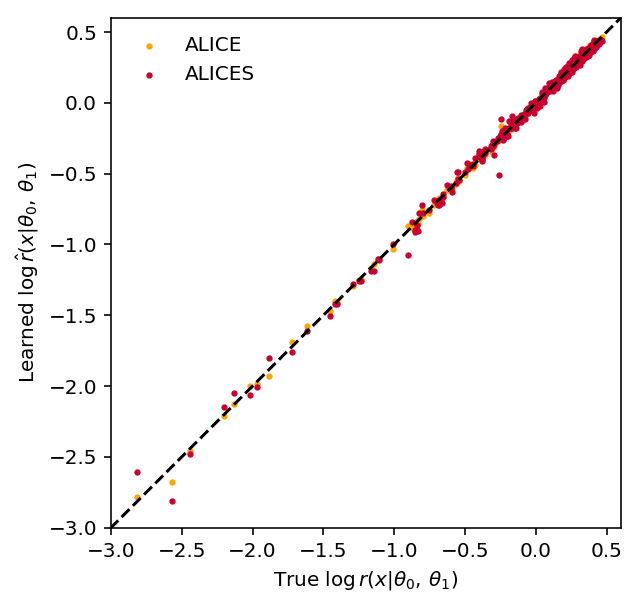

In [51]:
xmin, xmax = -3., 0.6
skip = 100

fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,1,True)))
ax = plt.gca()
  
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1.5, c=colors[truth_index])

for s in [7,8]:
    plt.scatter(np.log(r_benchmark[truth_index][::skip]),
                np.log(r_benchmark[s][::skip]),
                marker='o', alpha=1., s=10., c=colors[s], lw=0., zorder=zorders[s],
                label=labels[s])

plt.legend(loc='upper left', edgecolor='white', facecolor='white', framealpha=1.)

plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log \, r(x| \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")

adjust_margins(1,4.5,1,True)
plt.savefig("../figures/constraints_followup.pdf")

# Expected contours from asymptotics

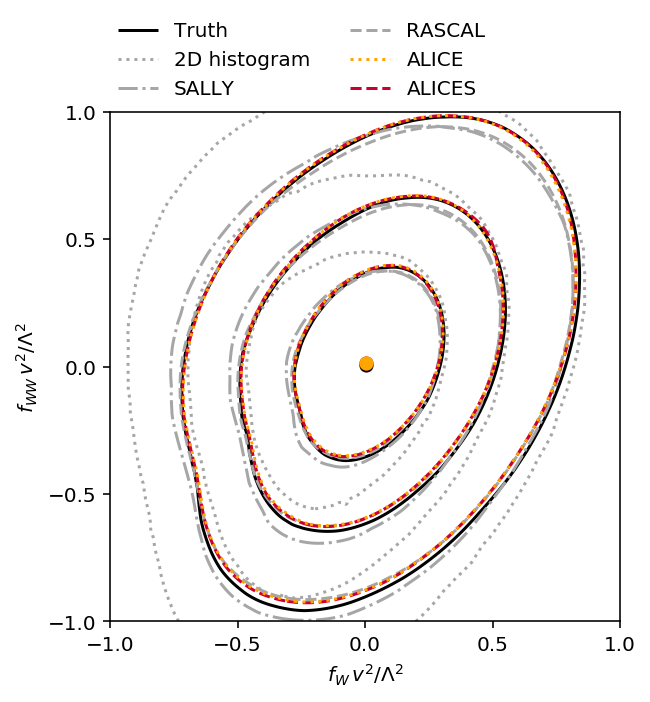

In [73]:
# Grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# Error band function
def plot_errorbands(xi, yi, zi_upper, zi_lower, color):
    for threshold in np.sort(1. - settings.confidence_levels):
        band = (zi_upper > threshold) * (zi_lower < threshold) + (zi_upper < threshold) * (zi_lower > threshold)
        plt.contourf(xi, yi, band, [0.5,2.5],
                     colors=color,
                     alpha=0.2)
        
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,1,True)))
ax = plt.gca()

# Error bands (envelope)
for s in [truth_index] + panel_indices[0]:
    #plot_errorbands(xi, yi,
    #                interpolated_p_values_asymptotics_upper_bound[s],
    #                interpolated_p_values_asymptotics_lower_bound[s],
    #                colors[s])

    # CL contours (median)
    cs = plt.contour(xi, yi, interpolated_p_values_asymptotics_median[s], 
                     np.sort(1. - settings.confidence_levels),
                     linewidths=linewidths[s], colors=colors[s],
                     zorder=zorders[s],
                     linestyles=linestyles[s])
    cs.collections[0].set_label(labels[s])

    # MLE
    if s in [truth_index, 7,8]:
        plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                    [yi[interpolated_expected_llr_mle[s][0]]],
                    marker='o', c=colors[s], s=50, lw=0, zorder=10 + zorders[s])

# Legend
plt.legend(loc='lower left', bbox_to_anchor=(-0.02,.99), ncol=2, frameon=False)

# Axis details
plt.xlim(-1, 1.)
plt.ylim(-1, 1.)
plt.xticks(np.linspace(-1.,1.,5))
plt.yticks(np.linspace(-1.,1.,5))
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")

adjust_margins(1,4.5,1,True)
plt.savefig("../figures/constraints_asymptotics_followup.pdf")


# Expected CL contours from NC: truth level

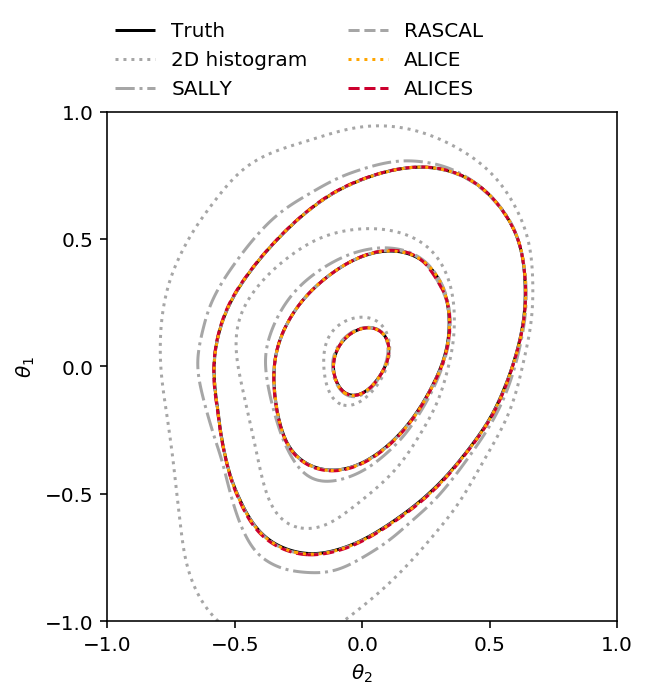

In [77]:
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,1,True)))
ax = plt.gca()

for i, s in enumerate([truth_index] + panel_indices[0]):
    if interpolated_cl_excluded[s] is None:
        continue

    for cl in range(len(interpolated_cl_excluded[truth_index])):
        cs = plt.contour(xi, yi, interpolated_cl_excluded[s][cl], [0.],
                         linewidths=linewidths[s], colors=colors[s],
                         linestyles=linestyles[s],
                         zorder=zorders[s])
        if cl==0:
            cs.collections[0].set_label(labels[s])

plt.legend(loc='lower left', bbox_to_anchor=(-0.02,0.99), ncol=2, frameon=False)

plt.xlim(-1, 1.)
plt.ylim(-1, 1.)
plt.xticks(np.linspace(-1.,1.,5))
plt.yticks(np.linspace(-1.,1.,5))
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$\theta_1$")

adjust_margins(1,4.5,1,True)
plt.savefig("../figures/constraints_followup.pdf")

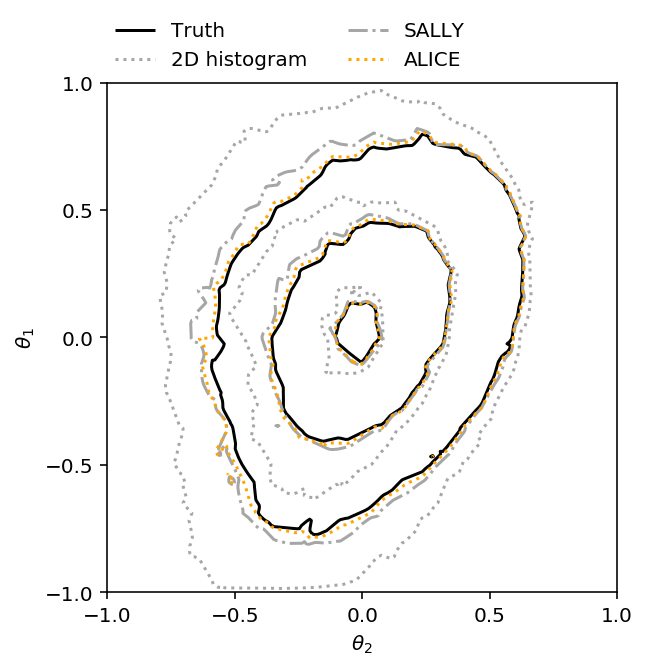

In [105]:
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,1,True)))
ax = plt.gca()

for i, s in enumerate([truth_index] + panel_indices[2]):
    if interpolated_cl_excluded[s] is None:
        continue

    for cl in range(len(interpolated_cl_excluded[truth_index])):
        cs = plt.contour(xi, yi, interpolated_cl_excluded[s][cl], [0.],
                         linewidths=linewidths[s], colors=colors[s],
                         linestyles=linestyles[s],
                         zorder=zorders[s])
        if cl==0:
            cs.collections[0].set_label(labels[s])

plt.legend(loc='lower left', bbox_to_anchor=(-0.02,0.99), ncol=2, frameon=False)

plt.xlim(-1, 1.)
plt.ylim(-1, 1.)
plt.xticks(np.linspace(-1.,1.,5))
plt.yticks(np.linspace(-1.,1.,5))
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$\theta_1$")

adjust_margins(1,4.5,1,True)
plt.savefig("../figures/constraints_100k_followup.pdf")

# Expected CL from NC: smearing

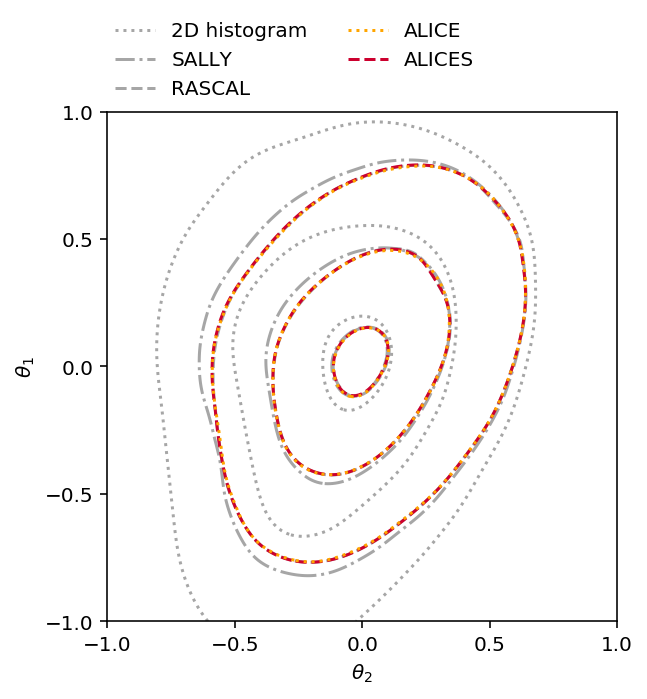

In [76]:
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,1,True)))
ax = plt.gca()

for i, s in enumerate(panel_indices[1]):
    if interpolated_cl_excluded[s] is None:
        continue

    for cl in range(len(interpolated_cl_excluded[truth_index])):
        cs = plt.contour(xi, yi, interpolated_cl_excluded[s][cl], [0.],
                         linewidths=linewidths[s], colors=colors[s],
                         linestyles=linestyles[s],
                         zorder=zorders[s])
        if cl==0:
            cs.collections[0].set_label(labels[s])

plt.legend(loc='lower left', bbox_to_anchor=(-0.02,0.99), ncol=2, frameon=False)

plt.xlim(-1, 1.)
plt.ylim(-1, 1.)
plt.xticks(np.linspace(-1.,1.,5))
plt.yticks(np.linspace(-1.,1.,5))
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$\theta_1$")

adjust_margins(1,4.5,1,True)
plt.savefig("../figures/constraints_smearing_followup.pdf")

TypeError: object of type 'NoneType' has no len()

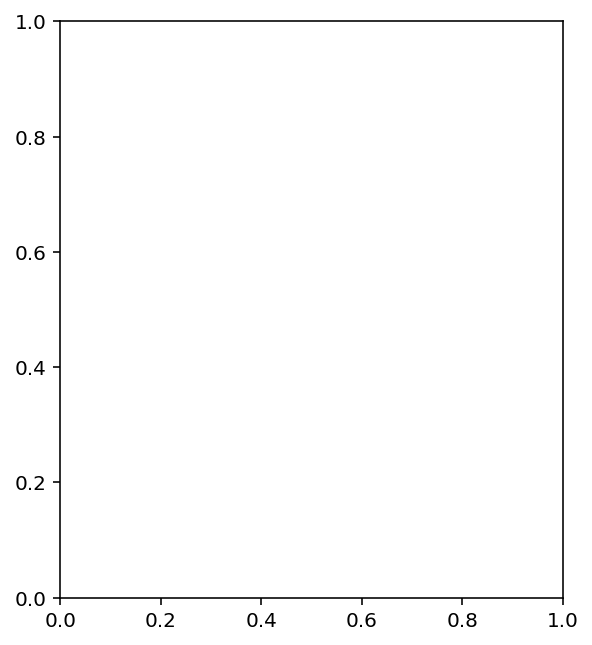

In [96]:
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,1,True)))
ax = plt.gca()

for i, s in enumerate(panel_indices[3]):
    if interpolated_cl_excluded[s] is None:
        continue

    for cl in range(len(interpolated_cl_excluded[truth_index])):
        cs = plt.contour(xi, yi, interpolated_cl_excluded[s][cl], [0.],
                         linewidths=linewidths[s], colors=colors[s],
                         linestyles=linestyles[s],
                         zorder=zorders[s])
        if cl==0:
            cs.collections[0].set_label(labels[s])

plt.legend(loc='lower left', bbox_to_anchor=(-0.02,0.99), ncol=2, frameon=False)

plt.xlim(-1, 1.)
plt.ylim(-1, 1.)
plt.xticks(np.linspace(-1.,1.,5))
plt.yticks(np.linspace(-1.,1.,5))
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$\theta_1$")

adjust_margins(1,4.5,1,True)
plt.savefig("../figures/constraints_smearing_100k_followup.pdf")